## Library Preparation

In [1]:
!pip install pytorch_lightning -qq
!pip install --upgrade wandb -qq
!pip install kaggle -qq
!pip install torchmetrics -qq

In [2]:
! mkdir ~/.kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download shifatearman/bananalsd

 46% 17.0M/36.9M [00:00<00:00, 62.0MB/s]
100% 36.9M/36.9M [00:00<00:00, 105MB/s] 


In [ ]:
! unzip bananalsd.zip

## Data Preparation

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings("ignore")

### Import datasets

In [3]:
# Use ImageFolder to create dataset(s)
data_dir = "/content/BananaLSD/OriginalSet"
# data_dir = "BananaLSD/OriginalSet"

dataset = datasets.ImageFolder(root=data_dir)

dataset

Dataset ImageFolder
    Number of datapoints: 937
    Root location: /content/BananaLSD/OriginalSet

In [4]:
# Get class names as a list
class_names = dataset.classes
class_names

['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']

In [5]:
# Can also get class names as a dict
class_dict = dataset.class_to_idx
class_dict

{'cordana': 0, 'healthy': 1, 'pestalotiopsis': 2, 'sigatoka': 3}

### Splitting datasets

In [6]:
# Splitting ratio
train_ratio = 0.8 * 0.8
val_ratio = 0.8 * 0.2
test_ratio = 0.2

# Hitung ukuran dataset untuk setiap bagian
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Bagi dataset menjadi bagian training, validasi, dan testing
seed = torch.Generator().manual_seed(42)
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=seed)

In [7]:
# Check the lengths
len(train_data), len(val_data), len(test_data)

(599, 149, 189)

### Apply data transformation on splitted data

In [8]:
class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [79]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = ApplyTransform(train_data, transform=train_transforms)
val_data = ApplyTransform(val_data, transform=test_transforms)
test_data = ApplyTransform(test_data, transform=test_transforms)

In [80]:
train_data.transform, val_data.transform, test_data.transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ))

### Apply data augmentation and convert it to dataloader

In [81]:
import os

# see how much cpu core -> for dataloader worker
os.cpu_count()

2

In [82]:
batch_size = 64

# train split dataloader
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          num_workers=2,
                          shuffle=True
                          )

# valid split dataoader
val_loader = DataLoader(val_data,
                        num_workers=2,
                        batch_size=batch_size
                        )

# test split dataloader
test_loader = DataLoader(test_data,
                         num_workers=2,
                         batch_size=batch_size
                         )

### Visualize some data

Image shape: torch.Size([64, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])



Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


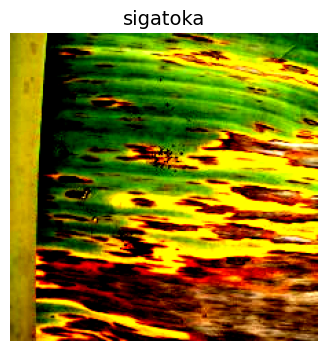

In [83]:
import matplotlib.pyplot as plt

img, label = next(iter(train_loader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print()

for id, (X, y) in enumerate(train_loader):
    # Rearrange the order of dimensions
    img_permute = X[0].permute(1, 2, 0)

    # Print out different shapes (before and after permute)
    print(f"Original shape: {X[0].shape} -> [color_channels, height, width]")
    print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

    # Plot the image
    plt.figure(figsize=(8, 4))
    plt.imshow(img_permute)
    plt.axis("off")
    plt.title(class_names[y[0]], fontsize=14);
    break

## Modelling

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchmetrics.functional import accuracy
import pytorch_lightning as pl

print(torch.cuda.is_available())

True


In [11]:
import wandb
wandb.login()

wandb: Currently logged in as: hiseulgi. Use `wandb login --relogin` to force relogin


True

### ResNet Lightning Model

In [22]:
class LitResNetTransferLearning(pl.LightningModule):
    def __init__(self, base_model, num_target_classes, lr=1e-3):
        super().__init__()

        # num of target classes
        self.num_target_classes = num_target_classes

        # loss
        self.loss = nn.CrossEntropyLoss()

        # learning rate for optimizer
        self.lr = lr

        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()

        # network layer
        # init a pretrained weight from base model
        backbone = base_model
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify num_target_classess
        self.classifier = nn.Linear(num_filters, self.num_target_classes)

    def forward(self, x: torch.Tensor):
        '''method used for inference input -> output'''
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'train_loss': loss, 'train_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'val_loss': loss, 'val_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        # Let's return preds to use it in a custom callback
        return preds

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'test_loss': loss, 'test_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

    def configure_optimizers(self):
        '''defines model optimizer'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y, "multiclass", num_classes=self.num_target_classes)
        return preds, loss, acc

In [23]:
INPUT_SHAPE = 3
OUTPUT_SHAPE = 4

pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
import torchvision.models as models

# resnet = models.resnet50(weights="DEFAULT")
# lit_resnet = LitResNetTransferLearning(resnet, OUTPUT_SHAPE)

### Wandb Setting & Callback

In [12]:
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# log image when validation step
class LogPredictionsCallback(Callback):

    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx = 0):
        """Called when the validation batch ends."""

        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case

        # Let's log 20 sample image predictions from first batch
        if batch_idx == 0:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]

            # Option 1: log images with `WandbLogger.log_image`
            trainer.logger.log_image(key='sample_images', images=images, caption=captions)

            # Option 2: log predictions as a Table
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            trainer.logger.log_table(key='sample_table', columns=columns, data=data)


log_predictions_callback = LogPredictionsCallback()

# Checkpoint
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

# Earlystopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min')



In [ ]:
from pytorch_lightning.loggers import WandbLogger

# wandb_logger = WandbLogger(project="banana-leaf-diseases",
#                            name="resnet50-0",
#                            tags=["resnet", "resnet-50"],
#                            log_model="all")

### Train the model with Trainer

In [ ]:
from pytorch_lightning import Trainer

# trainer = Trainer(
#     logger=wandb_logger.
#     callbacks=[log_predictions_callback,
#                checkpoint_callback,
#                early_stopping_callback],
#     accelerator="gpu",
#     max_epochs=50)

In [ ]:
trainer.fit(lit_resnet, train_loader, val_loader)
wandb.finish()

### Train in a Loop

In [9]:
def train_and_log(
    run_name,
    run_tags,
    model,
    train_loader,
    val_loader
    ):
    pl.seed_everything(42)

    wandb_logger = WandbLogger(project="banana-leaf-diseases",
                               name=run_name,
                               tags=run_tags,
                               log_model="all")

    log_predictions_callback = LogPredictionsCallback()

    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

    trainer = Trainer(
        logger=wandb_logger,
        callbacks=[
               log_predictions_callback,
               early_stopping_callback
               ],
        accelerator="gpu",
        max_epochs=50)

    trainer.fit(model, train_loader, val_loader)

    wandb.log({"final_train_loss": trainer.callback_metrics["train_loss"],
               "final_val_loss": trainer.callback_metrics["val_loss"]})

    wandb.finish()

#### ResNet

In [ ]:
base_models = {
    "resnet18": [["resnet", "resnet18"], models.resnet18(weights="DEFAULT")],
    "resnet34": [["resnet", "resnet34"], models.resnet34(weights="DEFAULT")],
    "resnet50": [["resnet", "resnet50"], models.resnet50(weights="DEFAULT")],
    "resnet101": [["resnet", "resnet101"], models.resnet101(weights="DEFAULT")],
    "resnet152": [["resnet", "resnet152"], models.resnet152(weights="DEFAULT")],
}

In [ ]:
OUTPUT_SHAPE = 4

for key, item in base_models.items():
    model_name = key+"-0"
    tags = item[0]
    base_model = item[1]

    print(f"Train on {model_name}")

    lit_model = LitResNetTransferLearning(base_model, OUTPUT_SHAPE)

    train_and_log(model_name, tags, lit_model, train_loader, val_loader)

    print("=================")
    print()
    print()
    print()

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Train on resnet18-0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | loss              | CrossEntropyLoss | 0     
1 | feature_extractor | Sequential       | 11.2 M
2 | classifier        | Linear           | 2.1 K 
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▃▅▅▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇██████████████▇████
train_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▄▆▇▇▇██████▇███████████▇███████████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,39
final_train_loss,0.15795
final_val_loss,0.10156


INFO:lightning_fabric.utilities.seed:Global seed set to 42





Train on resnet34-0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | loss              | CrossEntropyLoss | 0     
1 | feature_extractor | Sequential       | 21.3 M
2 | classifier        | Linear           | 2.1 K 
-------------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.147    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▄▅▆▇▇▇▇▇█▇▇▇▇█▇█▇█████████████████
train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▆▇████████████████████████████████
val_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,34
final_train_loss,0.17346
final_val_loss,0.12824


INFO:lightning_fabric.utilities.seed:Global seed set to 42





Train on resnet50-0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | loss              | CrossEntropyLoss | 0     
1 | feature_extractor | Sequential       | 23.5 M
2 | classifier        | Linear           | 8.2 K 
-------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.065    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▄▆▇▇▇██▇███████████████████████████████
train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▇▇▇████████████████████████████████████
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
final_train_loss,0.05675
final_val_loss,0.07691


INFO:lightning_fabric.utilities.seed:Global seed set to 42





Train on resnet101-0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | loss              | CrossEntropyLoss | 0     
1 | feature_extractor | Sequential       | 42.5 M
2 | classifier        | Linear           | 8.2 K 
-------------------------------------------------------
42.5 M    Trainable params
0         Non-trainable params
42.5 M    Total params
170.033   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▄▇▇▇█▇█████████████████████████████████
train_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
val_accuracy,▁▇▇▇▇███████████████████████████████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,42
final_train_loss,0.05375
final_val_loss,0.08615


INFO:lightning_fabric.utilities.seed:Global seed set to 42





Train on resnet152-0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | loss              | CrossEntropyLoss | 0     
1 | feature_extractor | Sequential       | 58.1 M
2 | classifier        | Linear           | 8.2 K 
-------------------------------------------------------
58.2 M    Trainable params
0         Non-trainable params
58.2 M    Total params
232.608   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▅▇▇▇▇██████████████████████████████████
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▇▇▇▇▇█▇███████▇████████████████████████
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
final_train_loss,0.03997
final_val_loss,0.07191


#### EficientNetV2

In [ ]:
class LitEfficientNetTransferLearning(pl.LightningModule):
    def __init__(self, base_model, num_target_classes, lr=1e-3):
        super().__init__()

        # num of target classes
        self.num_target_classes = num_target_classes

        # loss
        self.loss = nn.CrossEntropyLoss()

        # learning rate for optimizer
        self.lr = lr

        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()

        # network layer
        # init a pretrained weight from base model
        backbone = base_model
        num_filters = backbone.classifier[1].in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify num_target_classess
        self.classifier = nn.Linear(num_filters, self.num_target_classes)

    def forward(self, x: torch.Tensor):
        '''method used for inference input -> output'''
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'train_loss': loss, 'train_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'val_loss': loss, 'val_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        # Let's return preds to use it in a custom callback
        return preds

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'test_loss': loss, 'test_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

    def configure_optimizers(self):
        '''defines model optimizer'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y, "multiclass", num_classes=self.num_target_classes)
        return preds, loss, acc

In [ ]:
base_models = {
    # "efficientnetv2-s": [["efficientnetv2", "efficientnetv2-s"], models.efficientnet_v2_s(weights="DEFAULT")],
    # "efficientnetv2-m": [["efficientnetv2", "efficientnetv2-m"], models.efficientnet_v2_m(weights="DEFAULT")],
    "efficientnetv2-l": [["efficientnetv2", "efficientnetv2-l"], models.efficientnet_v2_l(weights="DEFAULT")],
}

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:03<00:00, 128MB/s] 


In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

OUTPUT_SHAPE = 4

for key, item in base_models.items():
    model_name = key+"-0"
    tags = item[0]
    base_model = item[1]

    print(f"Train on {model_name}")

    lit_model = LitEfficientNetTransferLearning(base_model, OUTPUT_SHAPE)

    train_and_log(model_name, tags, lit_model, train_loader, val_loader)

    print("=================")
    print()
    print()
    print()

Train on efficientnetv2-l-0


INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | loss              | CrossEntropyLoss | 0     
1 | feature_extractor | Sequential       | 117 M 
2 | classifier        | Linear           | 5.1 K 
-------------------------------------------------------
117 M     Trainable params
0         Non-trainable params
117 M     Total params
468.958   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

wandb: ERROR Control-C detected -- Run data was not synced


#### MobileNetV3

In [30]:
class LitMobileNetTransferLearning(pl.LightningModule):
    def __init__(self, base_model, num_target_classes, lr=1e-3):
        super().__init__()

        # num of target classes
        self.num_target_classes = num_target_classes

        # loss
        self.loss = nn.CrossEntropyLoss()

        # learning rate for optimizer
        self.lr = lr

        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()

        # network layer
        # init a pretrained weight from base model
        backbone = base_model
        num_filters = backbone.classifier[0].in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify num_target_classess
        self.classifier = nn.Linear(num_filters, self.num_target_classes)

    def forward(self, x: torch.Tensor):
        '''method used for inference input -> output'''
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'train_loss': loss, 'train_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'val_loss': loss, 'val_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        # Let's return preds to use it in a custom callback
        return preds

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'test_loss': loss, 'test_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

    def configure_optimizers(self):
        '''defines model optimizer'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y, "multiclass", num_classes=self.num_target_classes)
        return preds, loss, acc

In [26]:
import torchvision.models as models

base_models = {
    "mobilenetv3-s": [["mobilenetv3", "mobilenetv3-s"], models.mobilenet_v3_small(weights="DEFAULT")],
    "mobilenetv3-l": [["mobilenetv3", "mobilenetv3-l"], models.mobilenet_v3_large(weights="DEFAULT")],
}

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 64.3MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 63.7MB/s]


In [31]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

OUTPUT_SHAPE = 4

for key, item in base_models.items():
    model_name = key+"-0"
    tags = item[0]
    base_model = item[1]

    print(f"Train on {model_name}")

    lit_model = LitMobileNetTransferLearning(base_model, OUTPUT_SHAPE)

    train_and_log(model_name, tags, lit_model, train_loader, val_loader)

    print("=================")
    print()
    print()
    print()

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Train on mobilenetv3-s-0


wandb: Currently logged in as: hiseulgi. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | loss              | CrossEntropyLoss | 0     
1 | feature_extractor | Sequential       | 927 K 
2 | classifier        | Linear           | 2.3 K 
-------------------------------------------------------
929 K     Trainable params
0         Non-trainable params
929 K     Total params
3.717     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▃▅▆▇▇▇▇▇▇▇█▇███████████████████████████
train_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▄▆▇▇▇▇▇██▇█████████████████████████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
final_train_loss,0.13226
final_val_loss,0.11126


INFO:lightning_fabric.utilities.seed:Global seed set to 42





Train on mobilenetv3-l-0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | loss              | CrossEntropyLoss | 0     
1 | feature_extractor | Sequential       | 3.0 M 
2 | classifier        | Linear           | 3.8 K 
-------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.903    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▃▅▆▇▇▇▇██▇█████████████████████████████
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_accuracy,▁▃▆▇▇▇▇▇████████████████████████████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
final_train_loss,0.08641
final_val_loss,0.07554
